In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  #gpuserver4

import torch
from IPython.core.interactiveshell import InteractiveShell
from torch.nn import functional as F
import fastai
from fastai.callback.tracker import SaveModelCallback
from fastai.vision.all import URLs, untar_data, get_image_files,ImageDataLoaders,\
parent_label,Resize,resnet34,resnet50,resnet101,resnet152,cnn_learner,error_rate,\
DataBlock,set_seed,CategoryBlock,RandomSplitter,imagenet_stats,ImageBlock,aug_transforms,\
Normalize,Recorder,accuracy,Adam,RocAuc,Learner,CrossEntropyLossFlat,ClassificationInterpretation
from fastai.torch_core import defaults
from fastcore.foundation import L
from functools import partial
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import random
import pdb
from scipy.ndimage import affine_transform
import scipy
import fastcore
import re
import pandas as pd
import cv2
import PIL
import sklearn.metrics as skm
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
from zipfile import ZipFile

# Load Data

In [2]:
with ZipFile('train_data.zip','r') as data:
    data_path = Path('./train')
    data.extractall(data_path)
    data.close()

# Create Datasets

In [3]:
garbage_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[
        *aug_transforms(min_scale=0.5, size=224),
        Normalize.from_stats(*imagenet_stats)
    ],
    )

# Check DataBlock

In [4]:
garbage_block.summary(source=data_path / 'train_data')

Setting-up type transforms pipelines
Found 14802 items
2 datasets of sizes 11842,2960
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      train/train_data/25/img_12197.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=544x338
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      train/train_data/25/img_12197.jpg
    applying parent_label gives
      25
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(18)

Final sample: (PILImage mode=RGB size=544x338, TensorCategory(18))


Setting up after_item: Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor --

# Check DataLoaders

Setting up after_item: Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.5, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


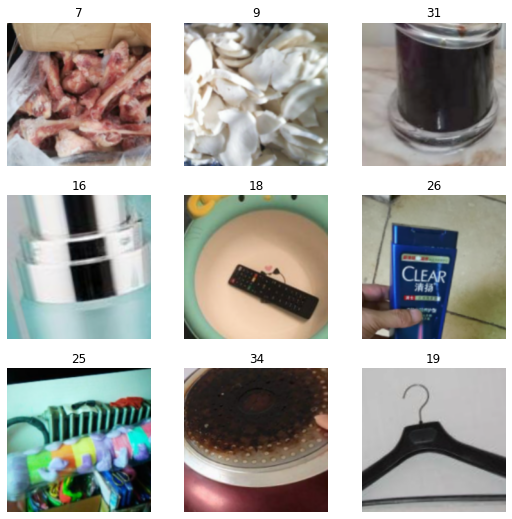

In [5]:
dls = garbage_block.dataloaders(
        source=data_path/'train_data',
        #Output process of dataloaders construction
        verbose=True,
        bs=128,
        drop_last = True
    )

dls.show_batch()

# Build Model

In [6]:
loss_func = CrossEntropyLossFlat()
learn = Learner(
    dls=dls,
    model=resnet34(pretrained=True),
    loss_func=loss_func,
    opt_func=Adam,
    # founder of fastai argue that it's a best default learning rate
    lr=1e-3,
    # no callback,
    cbs=None,
    metrics=[accuracy],
    # load data from dataloaders
    path=None,
    # save model in models dir
    model_dir='models',
    # use weight decay
    wd=2e-4,
    # weight decay do not used for BN
    wd_bn_bias=False,
    # BN are trainable during frozen body
    train_bn=True,
    # momentum
    moms=(0.95, 0.85, 0.95),
)

In [7]:
learn.summary()

ResNet (Input shape: ['128 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 64 x 112 x 11  9,408      True      
________________________________________________________________
BatchNorm2d          128 x 64 x 112 x 11  128        True      
________________________________________________________________
ReLU                 128 x 64 x 112 x 11  0          False     
________________________________________________________________
MaxPool2d            128 x 64 x 56 x 56   0          False     
________________________________________________________________
Conv2d               128 x 64 x 56 x 56   36,864     True      
________________________________________________________________
BatchNorm2d          128 x 64 x 56 x 56   128        True      
________________________________________________________________
ReLU                 128 x 64 x 56 x 56   0          False     
____________________________________________________

In [8]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.164972,1.628852,0.553378,01:23
1,1.174313,0.922558,0.739865,01:23
2,0.639915,0.707670,0.800000,01:19


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.0005754399462603033)

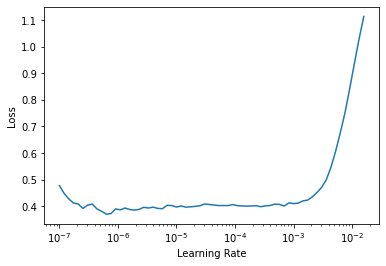

In [9]:
learn.lr_find()

In [10]:
learn.unfreeze()
learn.fit_one_cycle(12,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.415184,0.701845,0.800676,01:14
1,0.383981,0.716938,0.803041,01:18
2,0.337924,0.705562,0.813851,01:12
3,0.283139,0.668371,0.814189,01:18
4,0.221879,0.707051,0.812162,01:14
5,0.198966,0.743171,0.807095,01:18
6,0.151597,0.684972,0.823311,01:16
7,0.119368,0.719429,0.818581,01:17
8,0.095476,0.712438,0.813514,01:17
9,0.080326,0.679082,0.826014,01:14


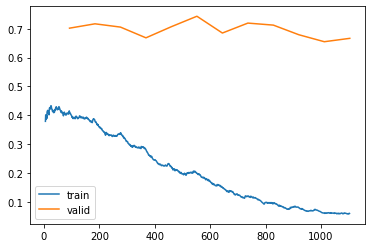

In [11]:
learn.recorder.plot_loss()

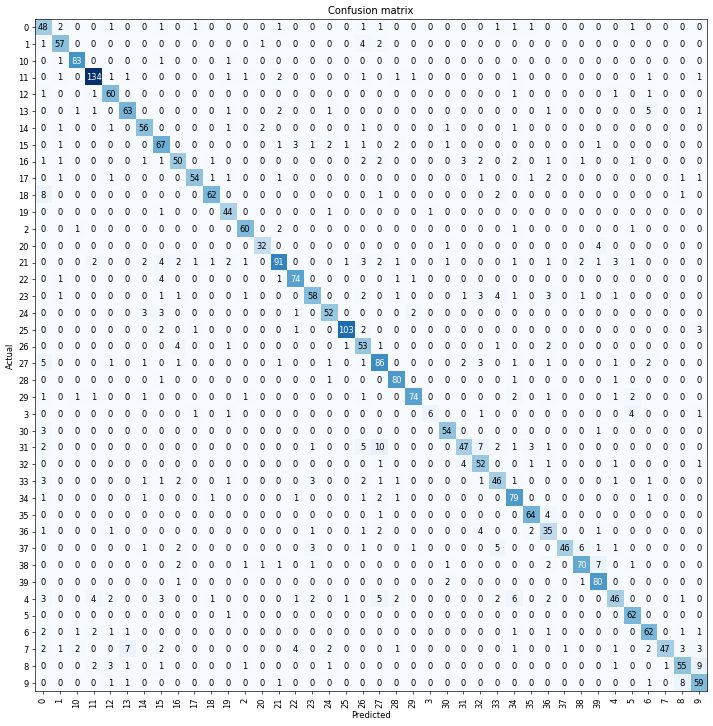

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
interp.most_confused(min_val=5)

[('31', '27', 10),
 ('8', '9', 9),
 ('18', '0', 8),
 ('9', '8', 8),
 ('31', '32', 7),
 ('38', '39', 7),
 ('7', '13', 7),
 ('37', '38', 6),
 ('4', '34', 6),
 ('13', '6', 5),
 ('27', '0', 5),
 ('31', '26', 5),
 ('37', '33', 5),
 ('4', '27', 5)]